In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

Using TensorFlow backend.


In [2]:
#Check Versions
print(tf.__version__) #1.15.0
print(keras.__version__) #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

In [3]:
n_data_points = 10**6
mu_min = -2
mu_max = 2
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

sigma_min = 1/3
sigma_max = 3
sigma_values = np.random.uniform(sigma_min, sigma_max, n_data_points)

We then sample from normal distributions with this $\mu$ value

In [4]:
X0 = [(np.random.normal(0, 1), mu_values[i], sigma_values[i]) for i in range(n_data_points)] # Note the zero in normal(0, 1) 
X1 = [(np.random.normal(mu_values[i], sigma_values[i]), mu_values[i], sigma_values[i]) for i in range(n_data_points)]

Please note that the samples in X0 are not paired with $\mu=0, \sigma = 1$ as this would make the task trivial. 

Instead it is paired with the $\mu, \sigma$ values uniformly sampled in the specified range [mu_min, mu_max] and [sigma_min, sigma_max].

For every value of $\mu$ in mu_values and every value of $\sigma$ in sigma_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ and $\sigma$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [5]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Build Model

In [6]:
inputs = Input((3,))
hidden_layer_1 = Dense(128, activation='relu')(inputs)
hidden_layer_2 = Dense(128, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(128, activation='relu')(hidden_layer_2)
outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train DCTR model

In [7]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=200, 
          batch_size = 10000,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1600000 samples, validate on 400000 samples
Epoch 1/200





1600000/1600000 [==============================] - 5s 3us/step - loss: 0.5529 - val_loss: 0.5373
Epoch 2/200
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.5349 - val_loss: 0.5366
Epoch 3/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5339 - val_loss: 0.5343
Epoch 4/200
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.5333 - val_loss: 0.5344
Epoch 5/200
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.5334 - val_loss: 0.5341
Epoch 6/200
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.5332 - val_loss: 0.5342
Epoch 7/200
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.5333 - val_loss: 0.5342
Epoch 8/200
1600000/1600000 [==============================] - 4s 2us/step - loss:

## Validate DCTR for any $\mu$ and $\sigma$

In [8]:
mu1 = 1
sigma1 = 1.5
assert mu1>=mu_min and mu1<=mu_max # choose mu1 in valid range
assert sigma1>=sigma_min and sigma1<=sigma_max # choose mu1 in valid range
X0_val = np.random.normal(0, 1, n_data_points)
X1_val = np.random.normal(mu1, sigma1, n_data_points)

In [9]:
X_input = np.array([(x, mu1, 1.5) for x in X0_val])

In [10]:
preds = dctr_model.predict(X_input)
weights = preds[:,1]/preds[:,0]

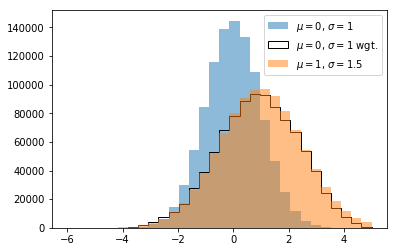

In [11]:
bins = np.linspace(-6,5,31)
plt.hist(X0_val, bins = bins, alpha = 0.5, label = r'$\mu=0$, $\sigma=1$')
plt.hist(X0_val, bins = bins, label = r'$\mu=0$, $\sigma=1$ wgt.', weights=weights, histtype='step', color='k')
plt.hist(X1_val, bins = bins, alpha = 0.5, label = r'$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
plt.legend()
plt.show()

# Saving Model

In [12]:
'''
model_json = dctr_model.to_json()
with open("dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("dctr_model.h5")
print("Saved model to disk")
'''

'\nmodel_json = dctr_model.to_json()\nwith open("dctr_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\ndctr_model.save_weights("dctr_model.h5")\nprint("Saved model to disk")\n'

# Alternative Fit

# Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

In [13]:
N = 10**6
#param = (mu, sigma)
theta0_param = (0,1) #this is the simulation ... N.B. this notation is reversed from above!
theta1_param = (1.3,0.7) #this is the data (the target)

epsilon =theta0_param[1]/2 #Smearing width

theta0_T = np.random.normal(theta0_param[0],theta0_param[1],N)
theta0_D = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_T]) #Detector smearing
theta0 = np.stack([theta0_T, theta0_D], axis = 1)

theta1_T = np.random.normal(theta1_param[0],theta1_param[1],N)
theta1_D = np.array([(x + np.random.normal(0, epsilon)) for x in theta1_T]) #Detector smearing
theta1 = np.stack([theta1_T, theta0_D], axis = 1)

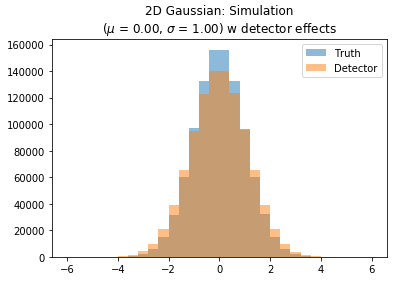

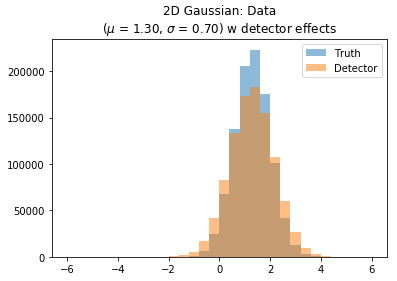

In [14]:
bins = np.linspace(-6,6,31)

plt.figure()
plt.title("2D Gaussian: Simulation\n($\mu$ = {:.2f}, $\sigma$ = {:.2f}) w detector effects".format(theta0_param[0], theta0_param[1]))
plt.hist(theta0_T, bins = bins, alpha = 0.5, label = 'Truth')
plt.hist(theta0_D, bins = bins, alpha = 0.5, label = 'Detector')
plt.legend()
#plt.savefig("2D Gaussian: Simulation ($\mu$ = {:.2f}, $\sigma$ = {:.2f}) w detector effects.png".format(theta0_param[0], theta0_param[1]))
plt.show()

plt.figure()
plt.title("2D Gaussian: Data\n($\mu$ = {:.2f}, $\sigma$ = {:.2f}) w detector effects".format(theta1_param[0], theta1_param[1]))
plt.hist(theta1_T, bins = bins, alpha = 0.5, label = 'Truth')
plt.hist(theta1_D, bins = bins, alpha = 0.5, label = 'Detector')
plt.legend()
#plt.savefig("2D Gaussian: Data ($\mu$ = {:.2f}, $\sigma$ = {:.2f}) w detector effects.png".format(theta1_param[0], theta1_param[1]))
plt.show()

In [15]:
#'Erasing' Truth level for data, we can't actually observe this
theta1 = np.stack([np.zeros_like(theta0_D), theta0_D], axis = 1)

In [16]:
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0_D,theta1_D])
y_true = np.concatenate([labels0,labels1]) 
# 'hiding' truth level for simulation in model output (used in reweighting)
truth_level = np.concatenate([theta0_T, theta1_T])
yvals = np.stack([y_true, truth_level], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0.5)

# Fitting Model

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

# Loading Model

In [17]:
# load json and create model
'''
json_file = open('dctr_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dctr_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
dctr_model.load_weights("2d_gaussian_dctr_model.h5")
print("Loaded model from disk")
'''


'\njson_file = open(\'dctr_model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\ndctr_model = keras.models.model_from_json(loaded_model_json)\n# load weights into new model\ndctr_model.load_weights("2d_gaussian_dctr_model.h5")\nprint("Loaded model from disk")\n'

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [18]:
def reweight(d): #from NN (DCTR)
    f = dctr_model(d)
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

# analytical reweight currently only works for sigma = 1
def analytical_reweight(d): #from analytical formula for normal distributions
    events = d[:,0]
    param = d[:,1]
    weights = K.exp(-(0.5*(events-param)**2)+(0.5*(events-0.0)**2))
    weights = K.expand_dims(weights, axis = 1)
    return weights

# Cross Section for $\mu$

In [19]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 500

def my_loss_wrapper(val=0):
    
    def my_loss(y_true,y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size)) 
        y_labels = tf.gather(y_true, [0], axis = 1) #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis = 1) # sim truth for reweighting

        theta_prime = [val, theta1_param[1]] #fixed theta_sigma = sigma_truth
    
        #creating tensor with same length as inputs, with theta_prime in every entry
        concat_input_and_params = K.ones(shape = (x_T.shape[0], 2))*theta_prime
        #combining and reshaping into correct format:
        data = K.concatenate((x_T, concat_input_and_params), axis=-1)
        
        w = reweight(data) # NN reweight
        
        # analytical reweight currently only works for sigma = 1
        # w = analytical_reweight(data) #functional analytical reweight
    
        # w = K.exp(-(0.5*(x-val)**2)+(0.5*(x-theta)**2)) #direct analytical reweight
        
        # Mean Squared Loss
        t_loss = y_labels*(y_labels - y_pred)**2+(w)*(1.-y_labels)*(y_labels - y_pred)**2
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_labels)*K.log(y_pred) +w*(1-y_labels)*K.log(1-y_labels))
        '''
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [20]:
thetas = np.linspace(-2,2,17)
lvals = []


for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, epochs=1, batch_size=500,validation_data=(np.array(X_test), y_test),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
print(lvals)

testing theta = : -2.0
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.0233 - acc: 0.3396 - val_loss: 0.0222 - val_acc: 0.3391
testing theta = : -1.75
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.0301 - acc: 0.3467 - val_loss: 0.0304 - val_acc: 0.3445
testing theta = : -1.5
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.0400 - acc: 0.3538 - val_loss: 0.0403 - val_acc: 0.3536
testing theta = : -1.25
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.0522 - acc: 0.3601 - val_loss: 0.0525 - val_acc: 0.3608
testing theta = : -1.0
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================

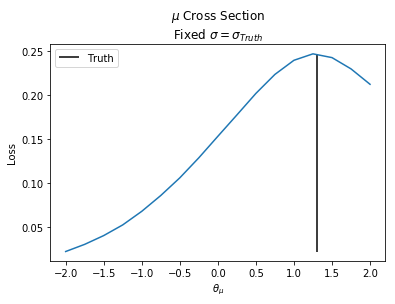

In [21]:
plt.plot(thetas,lvals)
plt.title("$\mu$ Cross Section\nFixed $\sigma = \sigma_{Truth}$")
plt.xlabel(r'$\theta_{\mu}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[0], ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-DetectorEffects-\mu cross section.png")
plt.show()

# Cross Section for $\sigma$

In [22]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()


def my_loss_wrapper(val=0):
    
    def my_loss(y_true,y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size)) 
        y_labels = tf.gather(y_true, [0], axis = 1) #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis = 1) # sim truth for reweighting

        theta_prime = [theta1_param[0], val] #fixed theta_mu = mu_truth
    
        #creating tensor with same length as inputs, with theta_prime in every entry
        concat_input_and_params = K.ones(shape = (x_T.shape[0], 2))*theta_prime
        #combining and reshaping into correct format:
        data = K.concatenate((x_T, concat_input_and_params), axis=-1)
        
        w = reweight(data) # NN reweight
        
        # w = analytical_reweight(data) #functional analytical reweight
    
        # w = K.exp(-(0.5*(x-val)**2)+(0.5*(x-theta)**2)) #direct analytical reweight
        
        # Mean Squared Loss
        t_loss = y_labels*(y_labels - y_pred)**2+(w)*(1.-y_labels)*(y_labels - y_pred)**2
        
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [23]:
thetas = np.linspace(0.5,2,16)
lvals = []


for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, epochs=1, batch_size=500,validation_data=(np.array(X_test), y_test),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
print(lvals)

testing theta = : 0.5
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2504 - acc: 0.1584 - val_loss: 0.2507 - val_acc: 0.1527
testing theta = : 0.6
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 12s 12us/step - loss: 0.2494 - acc: 0.1567 - val_loss: 0.2501 - val_acc: 0.1604
testing theta = : 0.7
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2464 - acc: 0.2418 - val_loss: 0.2471 - val_acc: 0.2273
testing theta = : 0.8
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 12s 12us/step - loss: 0.2428 - acc: 0.3452 - val_loss: 0.2433 - val_acc: 0.3510
testing theta = : 0.9
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [=============================

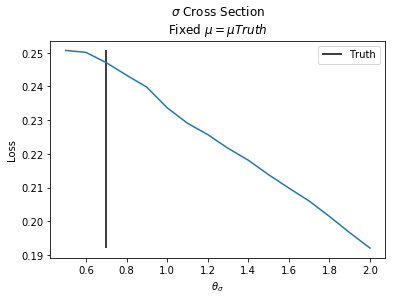

In [24]:
plt.plot(thetas,lvals)
plt.title("$\sigma$ Cross Section\nFixed $\mu = \mu{Truth}$")
plt.xlabel(r'$\theta_{\sigma}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[1], ymin = np.min(lvals), ymax = np.max(lvals), label = 'Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-DetectorEffects-\sigma cross section.png")
plt.show()

# Creating Model

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

# Building and Training Fitting Model

In [25]:
print_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = [0, 1]
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

In [26]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=(2,),
                                                         initializer = keras.initializers.Constant(value = theta_fit_init),
                                                         trainable=True)
model_fit.summary()

train_theta = False

batch_size = 1000
lr = 5e-5 #smaller learning rate yields better precision
epochs = 400 #but requires more epochs to train
optimizer = keras.optimizers.Adam(lr=lr)

def my_loss_wrapper_fit(mysign = 1):
    theta = 0. #starting value
    #Getting theta0:
    if train_theta == False:
        theta_prime = model_fit.layers[-1].get_weights()[0] #when not training theta, fetch as np array 
    else:
        theta_prime = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
    
    def my_loss(y_true,y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size)) 
        y_labels = tf.gather(y_true, [0], axis = 1) #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis = 1) # sim truth for reweighting
        
        #creating tensor with same length as inputs, with theta_prime in every entry
        concat_input_and_params = K.ones(shape = (x_T.shape[0], 2), dtype=tf.float32)*theta_prime
        data = K.concatenate((x_T, concat_input_and_params), axis=-1)
        
        w = reweight(data) #NN reweight
        
        # ANALYTICAL REWEIGHT ONLY WORKS FOR SIGMA = 1 RIGHT NOW
        #w = analytical_reweight(data) #functional analytical reweight
    
        #w = K.exp(-(0.5*(x-theta0)**2)+(0.5*(x-theta)**2)) #direct analytical reweight
        # Mean Squared Loss
        t_loss = mysign*(y_labels*(y_labels - y_pred)**2+(w)*(1.-y_labels)*(y_labels - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        """epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))"""
        
        return K.mean(t_loss)
    return my_loss
    
for k in range(epochs):    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer, loss=my_loss_wrapper_fit(-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)    
    pass
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 2         
Total params: 16,899
Trainable params: 16,899
Non-trainable params: 0
_________________________________________________________________
Epoch:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 9s

1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2502 - acc: 0.1700 - val_loss: 0.2508 - val_acc: 0.1640
. theta fit =  [1.2637912 0.521704 ]
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 11s 11us/step - loss: -0.2501 - acc: 0.1636 - val_loss: -0.2508 - val_acc: 0.1640
. theta fit =  [1.2687122  0.52401286]
Epoch:  15
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2501 - acc: 0.1653 - val_loss: 0.2508 - val_acc: 0.1647
. theta fit =  [1.2687122  0.52401286]
Training theta
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/1
1000000/1000000 [==============================] - 11s 11us/step - loss: -0.2501 - acc: 0.1644 - val_loss: -0.2509 - val_acc: 0.1647
. theta fit =  [1.2855867 0.5259864]
Epoch:  16
Training g
Train on 1000000 samples, validate on 1000000 samples


KeyboardInterrupt: 

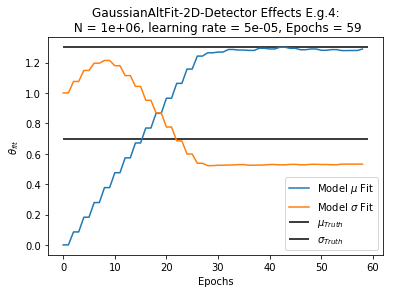

In [27]:
fit_vals = np.array(fit_vals)

plt.plot(fit_vals[:,0], label='Model $\mu$ Fit')
plt.plot(fit_vals[:,1], label='Model $\sigma$ Fit')
plt.hlines(theta1_param[0], 0, len(fit_vals), label = '$\mu_{Truth}$')
plt.hlines(theta1_param[1], 0, len(fit_vals), label = '$\sigma_{Truth}$')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("GaussianAltFit-2D-Detector Effects E.g.4:\n N = {:.0e}, learning rate = {:.0e}, Epochs = {:.0f}".format(N, lr, len(fit_vals)))

plt.savefig("GaussianAltFit-2D-Detector Effects eg4: N = {:.0e}, learning rate = {:.0e}, Epochs = {:.0f}.png".format(N, lr, len(fit_vals)))
plt.show()


In [36]:
correct_weights = np.array([[theta1_param[0], theta1_param[1]]])

model_fit.layers[-1].set_weights(correct_weights)
print(model_fit.evaluate(x=X_train, y=y_test, batch_size = 1000))
print("^", model_fit.metrics_names)

1000000/1000000 [==============================] - 3s 3us/step
[0.2719522885531187, 0.24994100038707256]
^ ['loss', 'acc']
